In [9]:
# Download kaggle data in Google Colab
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"jasonch8686","key":"712a2bf64edae0f77c9d6585e0ef137d"}'}

In [10]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
! kaggle datasets download -d 'simonezappatini/body-fat-extended-dataset'

body-fat-extended-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
# 建立一個名為body-fat的資料夾
! mkdir body-fat

mkdir: cannot create directory ‘body-fat’: File exists


In [7]:
# 將剛剛載下來的.zip壓縮檔解壓縮進body-fat資料夾裡
! unzip body-fat-extended-dataset.zip -d body-fat

Archive:  body-fat-extended-dataset.zip
replace body-fat/BodyFat - Extended.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
from sklearn.model_selection import train_test_split, cross_validate, KFold,  GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
import sklearn.linear_model as skl

In [13]:
import pandas as pd
import numpy as np
df = pd.read_csv('body-fat/BodyFat - Extended.csv')
df

,BodyFat,Original,Sex,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.30,Y,M,23,69.9700,1.7200,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.10,Y,M,22,78.5900,1.8400,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.30,Y,M,22,69.8500,1.6800,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.40,Y,M,26,83.8000,1.8400,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.70,Y,M,24,83.5800,1.8100,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,30.40,N,F,23,59.8752,1.5621,31.3,89.0,71.0,98.5,56.0,36.2,21.0,28.0,24.5,16.3
432,7.47,N,F,21,48.5352,1.5748,29.5,79.0,62.5,89.0,49.0,33.0,20.0,25.0,22.0,15.5
433,11.98,N,F,20,51.7104,1.5748,31.5,81.5,61.5,90.0,49.5,32.0,19.5,27.5,22.5,15.0
434,11.24,N,F,22,50.8032,1.6510,30.5,85.0,64.0,88.0,45.0,32.0,19.5,24.0,21.5,15.0


BodyFat (percent body fat)\
Original (Y/N if sample comes from the original dataset)\
Sex (M/F)\
Age (years)\
Weight (kg)\
Height (m)\
Neck (circumference in cm)：脖圍\
Chest (circumference in cm)：胸圍\
Abdomen (circumference in cm)：腰圍\
Hip (circumference in cm)：臀圍\
Thigh (middle part, circumference in cm)：大腿圍\
Knee (circumference in cm)：膝圍\
Ankle (circumference in cm)：腳踝圍\
Biceps (circumference in cm)：二頭圍\
Forearm (circumference in cm)：前臂圍\
Wrist (circumference in cm):手腕

In [14]:
#去除不必要欄位：Original、將Height單位變成公分、查看缺失值

df.drop(columns=['Original'], inplace=True)

df['Height']=df['Height']*100

print("NaN values:")
display(df.isna().sum())

NaN values:


BodyFat    0
Sex        0
Age        0
Weight     0
Height     0
Neck       0
Chest      0
Abdomen    0
Hip        0
Thigh      0
Knee       0
Ankle      0
Biceps     0
Forearm    0
Wrist      0
dtype: int64

In [15]:
print("data info:")
display(df.info())

print("first 5 rows:")
display(df.head())

data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BodyFat  436 non-null    float64
 1   Sex      436 non-null    object 
 2   Age      436 non-null    int64  
 3   Weight   436 non-null    float64
 4   Height   436 non-null    float64
 5   Neck     436 non-null    float64
 6   Chest    436 non-null    float64
 7   Abdomen  436 non-null    float64
 8   Hip      436 non-null    float64
 9   Thigh    436 non-null    float64
 10  Knee     436 non-null    float64
 11  Ankle    436 non-null    float64
 12  Biceps   436 non-null    float64
 13  Forearm  436 non-null    float64
 14  Wrist    436 non-null    float64
dtypes: float64(13), int64(1), object(1)
memory usage: 51.2+ KB


None

first 5 rows:


,BodyFat,Sex,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,M,23,69.97,172.0,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,M,22,78.59,184.0,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,M,22,69.85,168.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,M,26,83.80,184.0,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,M,24,83.58,181.0,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


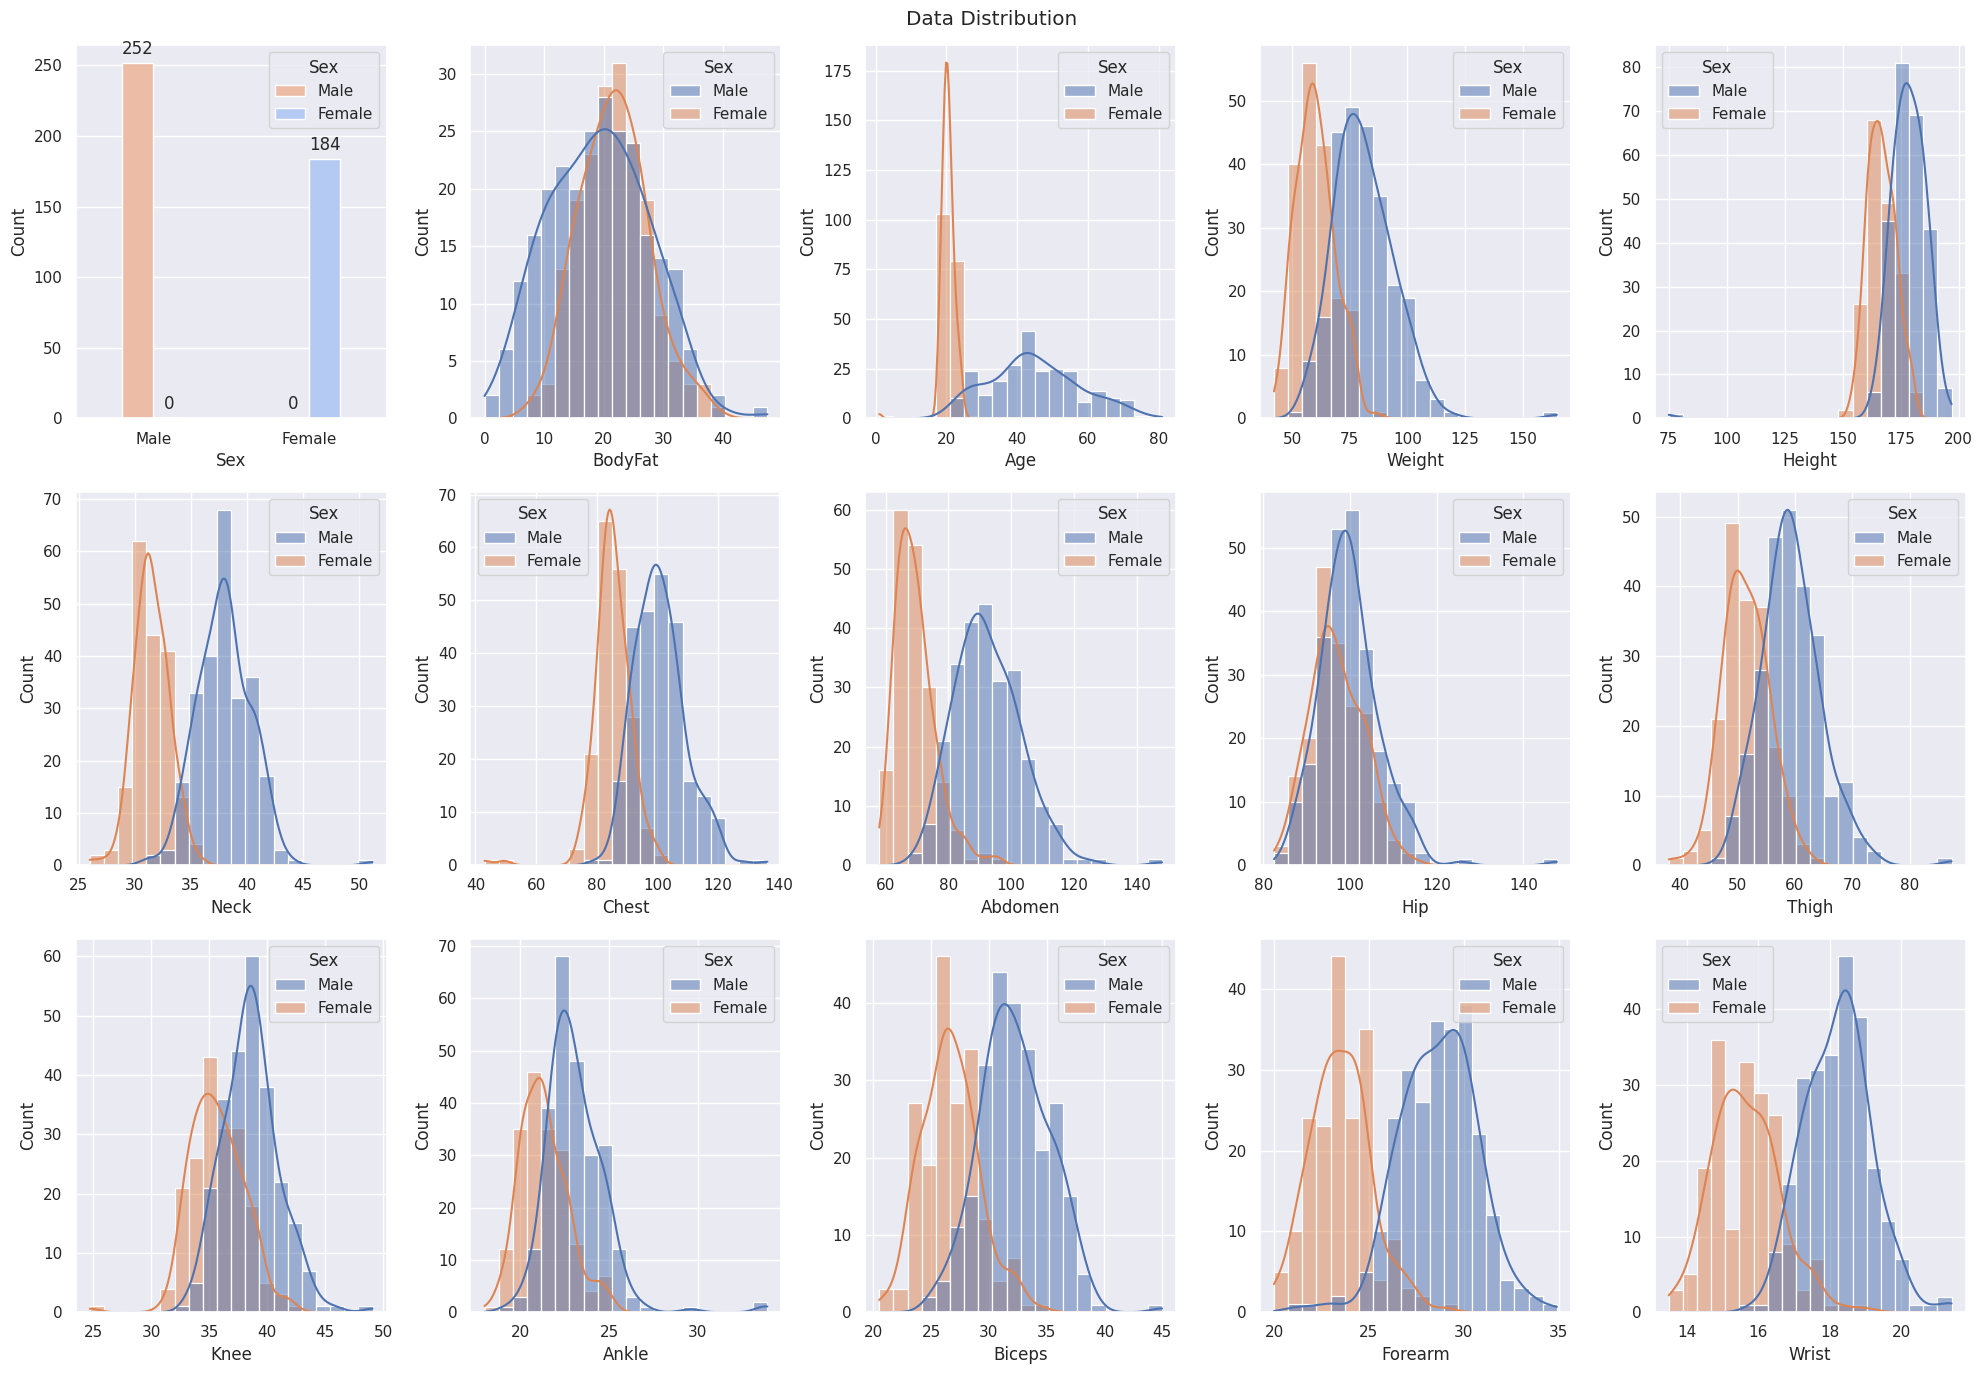

In [16]:
#畫出各變數分布狀況

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

df['Sex'] = df['Sex'].replace({'M': 'Male', 'F': 'Female'})

figure, axes = plt.subplots(3, 5, figsize=(20, 14))
figure.suptitle("Data Distribution")
axes = axes.flatten()
ax = sns.countplot(data=df, x='Sex', hue='Sex', ax=axes[0], width=0.4, palette="coolwarm_r")
ax.set_ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, 10), textcoords='offset points')
count = 1
columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
for col in columns:
    sns.histplot(data=df, x=col, hue='Sex', bins=20, kde=True, ax=axes[count])
    count += 1
plt.tight_layout()

可看出除臀圍外，其餘部位數值男性皆高於女性

In [17]:
#轉換Onehotencoding

sex_mapping = {'Male': 1, 'Female': 0}

df['Sex'] = df['Sex'].map(sex_mapping)
display(df.head())

,BodyFat,Sex,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,1,23,69.97,172.0,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,1,22,78.59,184.0,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,1,22,69.85,168.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,1,26,83.80,184.0,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,1,24,83.58,181.0,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


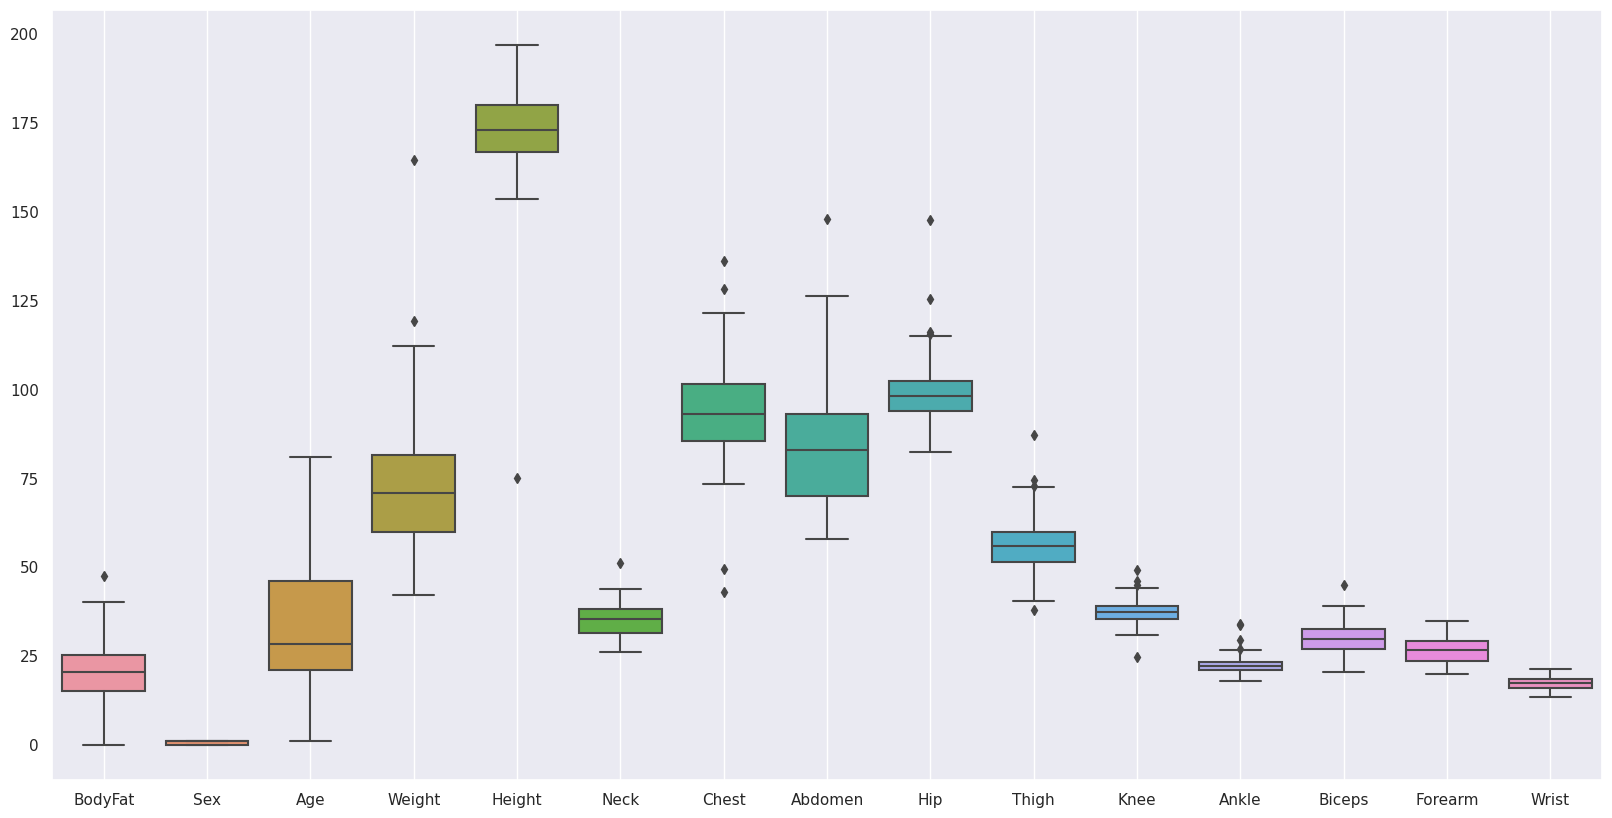

In [18]:
#檢查outlier

plt.figure(figsize=(20,10), facecolor='white')
sns.boxplot(data=df)
plt.grid()
plt.show()

In [19]:
#去除outlier

Q1 = df.quantile(0.25)
Q3 = df.quantile (0.75)

IQR = Q3 - Q1

df_nooutlier = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

before_rows = df.shape[0]

filtered_rows = df_nooutlier.shape[0]
print("Before: ", before_rows, " - After: ", filtered_rows)

Before:  436  - After:  420


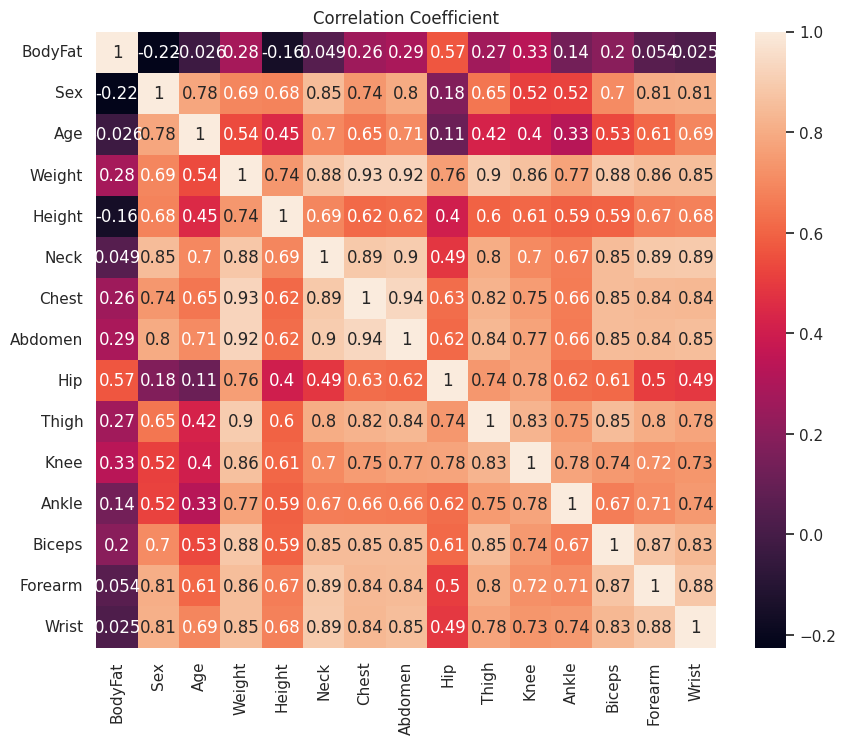

In [20]:
#畫相關性熱圖

plt.figure(figsize=(10, 8))
sns.heatmap(df_nooutlier.corr(), annot=True)
plt.title("Correlation Coefficient")
plt.show()

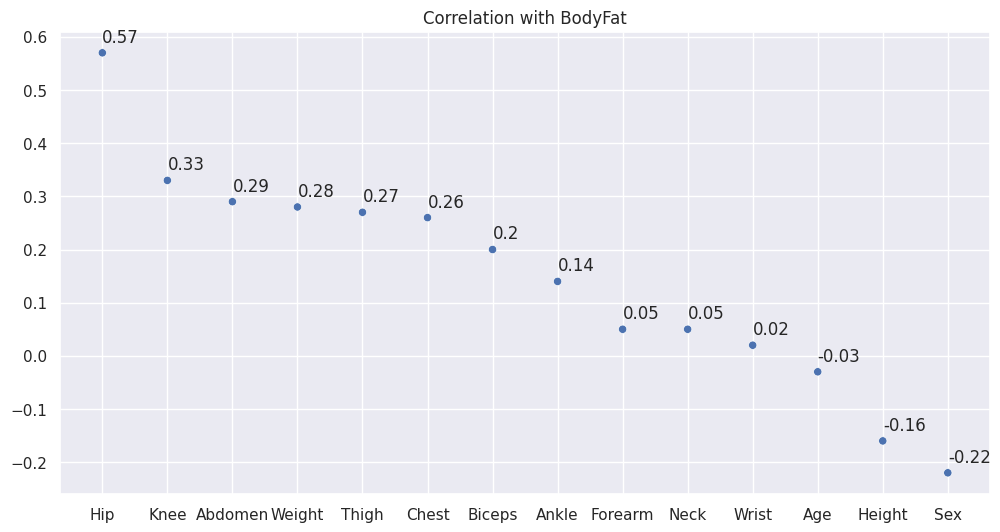

In [21]:
#畫各變數與BodyFat之相關係數，遞減排列

bodyfat_corr = df_nooutlier.corr()['BodyFat']
sorted_corr = bodyfat_corr.sort_values(ascending=False)
sorted_corr = pd.DataFrame(sorted_corr).round(2)
sorted_corr = sorted_corr.drop(["BodyFat"], axis=0)

plt.figure(figsize=(12, 6))
sns.scatterplot(sorted_corr, legend=False)
for index, row in sorted_corr.iterrows():
    plt.text(index, row['BodyFat']+0.02, row['BodyFat'])
plt.title("Correlation with BodyFat")
plt.show()

In [72]:
X = df.drop(columns=['BodyFat'])
y = df['BodyFat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [73]:
# scale on train data and apply it to test data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

In [74]:
# Preparation for KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2)

def adjusted_r2(y_true, y_pred, num_features):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_features - 1))
    return adj_r2

scoring = {'MSE': 'neg_mean_squared_error',
           'MAE': 'neg_mean_absolute_error',
           'R-squared': 'r2',
           'adj-R2': make_scorer(adjusted_r2, num_features=X.shape[1])}

### LinearRegression

In [25]:
from sklearn.linear_model import LinearRegression

# model
model = LinearRegression()

# train
model.fit(x_train_scaled, y_train)

LinearRegression()

In [26]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(x_train_scaled)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                BodyFat   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     55.09
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           1.41e-75
Time:                        03:26:40   Log-Likelihood:                -922.19
No. Observations:                 327   AIC:                             1874.
Df Residuals:                     312   BIC:                             1931.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9696      0.230     86.878      0.0

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

n = len(y)
k = X.shape[1]

# eval on train data
y_train_pred = model.predict(x_train_scaled)

mse_train = mean_squared_error(y_train, y_train_pred).round(3)
mae_train = mean_absolute_error(y_train, y_train_pred).round(3)
r2_train = r2_score(y_train, y_train_pred).round(3)
adj_r2_train = 1 - ((1 - r2_train) * (n - 1) / (n - k - 1))

# eval on test data
y_test_pred = model.predict(x_test_scaled)

mse_test = mean_squared_error(y_test, y_test_pred).round(3)
mae_test = mean_absolute_error(y_test, y_test_pred).round(3)
r2_test = r2_score(y_test, y_test_pred).round(3)
adj_r2_test = 1 - ((1 - r2_test) * (n - 1) / (n - k - 1))

print(f"Train | Mean Squared Error: {mse_train} | Mean Absolute Error: {mae_train} |R-squared: {r2_train}| adj-R2: {adj_r2_train}")
print(f"Test | Mean Squared Error: {mse_test} | Mean Absolute Error: {mae_test} | R-squared: {r2_test}| adj-R2: {adj_r2_test}")

Train | Mean Squared Error: 16.5 | Mean Absolute Error: 3.282 |R-squared: 0.712| adj-R2: 0.7024228028503563
Test | Mean Squared Error: 18.017 | Mean Absolute Error: 3.369 | R-squared: 0.653| adj-R2: 0.6414608076009501


In [84]:
lr_coef = model.coef_.round(3)
lr_interc = model.intercept_.round(3)
print("coefficient:")
for idx, col in enumerate(X_train.columns):
    print(f"{col}: {lr_coef[idx]}")
print("\ny-intercept:", lr_interc)

coefficient:
Sex: -7.525
Age: 1.165
Weight: -1.792
Height: -0.985
Neck: -1.831
Chest: -0.0
Abdomen: 9.438
Hip: 0.965
Thigh: 1.051
Knee: 0.445
Ankle: -0.19
Biceps: 0.716
Forearm: 1.418
Wrist: -2.03

y-intercept: 19.97


In [85]:
results = cross_validate(model, X, y, cv=kf, scoring=scoring)

average_mse = -results['test_MSE'].mean().round(3)
average_r2 = results['test_R-squared'].mean().round(3)
average_mae = -results['test_MAE'].mean().round(3)
average_adj_r2 = results['test_adj-R2'].mean()

print(f"KFold | Mean Squared Error: {average_mse} | Mean Absolute Error: {average_mae} | R-squared: {average_r2}| adj-R2: {average_adj_r2}")

KFold | Mean Squared Error: 17.88 | Mean Absolute Error: 3.41 | R-squared: 0.681| adj-R2: 0.6192247199365456


### Ridge

Text(0.5, 1.0, 'Ridge coefficients as a function of the regularization')

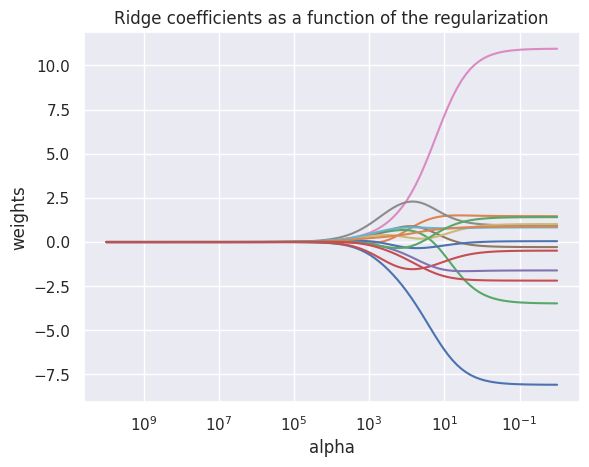

In [86]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import scale

alphas = 10**np.linspace(10,-2,100)

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y) # We standardize features before ridge regression
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')

In [31]:


# determine the best hyperparameter(alpha)
ridge_model = Ridge()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 100]}

grid_search = GridSearchCV(ridge_model, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(x_train_scaled, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f"best alpha: {best_alpha}")

best alpha: 0.1


In [32]:
# model
model = Ridge(alpha=best_alpha)

# train
model.fit(x_train_scaled, y_train)

Ridge(alpha=0.1)

In [33]:
n = len(y)
k = X.shape[1]

# eval on train data
y_train_pred = model.predict(x_train_scaled)

mse_train = mean_squared_error(y_train, y_train_pred).round(3)
mae_train = mean_absolute_error(y_train, y_train_pred).round(3)
r2_train = r2_score(y_train, y_train_pred).round(3)
adj_r2_train = 1 - ((1 - r2_train) * (n - 1) / (n - k - 1))

# eval on test data
y_test_pred = model.predict(x_test_scaled)

mse_test = mean_squared_error(y_test, y_test_pred).round(3)
mae_test = mean_absolute_error(y_test, y_test_pred).round(3)
r2_test = r2_score(y_test, y_test_pred).round(3)
adj_r2_test = 1 - ((1 - r2_test) * (n - 1) / (n - k - 1))

print(f"Train | Mean Squared Error: {mse_train} | Mean Absolute Error: {mae_train} | R-squared: {r2_train}| adj-R2: {adj_r2_train}")
print(f"Test | Mean Squared Error: {mse_test} | Mean Absolute Error: {mae_test} | R-squared: {r2_test}| adj-R2: {adj_r2_test}")

Train | Mean Squared Error: 16.485 | Mean Absolute Error: 3.287 | R-squared: 0.712| adj-R2: 0.7024228028503563
Test | Mean Squared Error: 17.789 | Mean Absolute Error: 3.368 | R-squared: 0.658| adj-R2: 0.6466270783847982


In [34]:
rr_coef = model.coef_.round(3)
rr_interc = model.intercept_.round(3)
print("coefficient:")
for idx, col in enumerate(X_train.columns):
    print(f"{col}: {rr_coef[idx]}")
print("\ny-intercept:", rr_interc)

coefficient:
Sex: -7.68
Age: 1.207
Weight: -2.315
Height: -0.878
Neck: -1.843
Chest: 0.018
Abdomen: 9.702
Hip: 1.014
Thigh: 1.16
Knee: 0.491
Ankle: -0.184
Biceps: 0.798
Forearm: 1.496
Wrist: -2.087

y-intercept: 19.97


In [ ]:
results = cross_validate(model, X, y, cv=kf, scoring=scoring)

average_mse = -results['test_MSE'].mean().round(3)
average_r2 = results['test_R-squared'].mean().round(3)
average_mae = -results['test_MAE'].mean().round(3)
average_adj_r2 = results['test_adj-R2'].mean()

print(f"KFold | Mean Squared Error: {average_mse} | Mean Absolute Error: {average_mae} | R-squared: {average_r2}| adj-R2: {average_adj_r2}")

KFold | Mean Squared Error: 17.803 | Mean Absolute Error: 3.408 | R-squared: 0.682| adj-R2: 0.6205567971139435


### Lasso

In [36]:
from sklearn.linear_model import Lasso

# determine the best hyperparameter(alpha)
lasso_model = Lasso()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 100]}

grid_search = GridSearchCV(lasso_model, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(x_train_scaled, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f"best alpha: {best_alpha}")

best alpha: 0.01


In [37]:
# create and train the Lasso regression model
model = Lasso(alpha=best_alpha)

# train
model.fit(x_train_scaled, y_train)

Lasso(alpha=0.01)

In [ ]:
n = len(y)
k = X.shape[1]

# eval on train data
y_train_pred = model.predict(x_train_scaled)

mse_train = mean_squared_error(y_train, y_train_pred).round(3)
mae_train = mean_absolute_error(y_train, y_train_pred).round(3)
r2_train = r2_score(y_train, y_train_pred).round(3)
adj_r2_train = 1 - ((1 - r2_train) * (n - 1) / (n - k - 1))

# eval on test data
y_test_pred = model.predict(x_test_scaled)

mse_test = mean_squared_error(y_test, y_test_pred).round(3)
mae_test = mean_absolute_error(y_test, y_test_pred).round(3)
r2_test = r2_score(y_test, y_test_pred).round(3)
adj_r2_test = 1 - ((1 - r2_test) * (n - 1) / (n - k - 1))

print(f"Train | Mean Squared Error: {mse_train} | Mean Absolute Error: {mae_train} | R-squared: {r2_train}| adj-R2: {adj_r2_train}")
print(f"Test | Mean Squared Error: {mse_test} | Mean Absolute Error: {mae_test} | R-squared: {r2_test}| adj-R2: {adj_r2_test}")

Train | Mean Squared Error: 16.5 | Mean Absolute Error: 3.282 | R-squared: 0.712| adj-R2: 0.7024228028503563
Test | Mean Squared Error: 18.017 | Mean Absolute Error: 3.369 | R-squared: 0.653| adj-R2: 0.6414608076009501


In [ ]:
lr_coef = model.coef_.round(3)
lr_interc = model.intercept_.round(3)
print("coefficient:")
for idx, col in enumerate(X_train.columns):
    print(f"{col}: {rr_coef[idx]}")
print("\ny-intercept:", rr_interc)

coefficient:
Sex: -7.68
Age: 1.207
Weight: -2.315
Height: -0.878
Neck: -1.843
Chest: 0.018
Abdomen: 9.702
Hip: 1.014
Thigh: 1.16
Knee: 0.491
Ankle: -0.184
Biceps: 0.798
Forearm: 1.496
Wrist: -2.087

y-intercept: 19.97


In [ ]:
results = cross_validate(model, X, y, cv=kf, scoring=scoring)

average_mse = -results['test_MSE'].mean().round(3)
average_r2 = results['test_R-squared'].mean().round(3)
average_mae = -results['test_MAE'].mean().round(3)
average_adj_r2 = results['test_adj-R2'].mean()

print(f"KFold | Mean Squared Error: {average_mse} | Mean Absolute Error: {average_mae} | R-squared: {average_r2}| adj-R2: {average_adj_r2}")

KFold | Mean Squared Error: 17.71 | Mean Absolute Error: 3.401 | R-squared: 0.684| adj-R2: 0.6222921787594855


###Lasso變數重要性

In [75]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

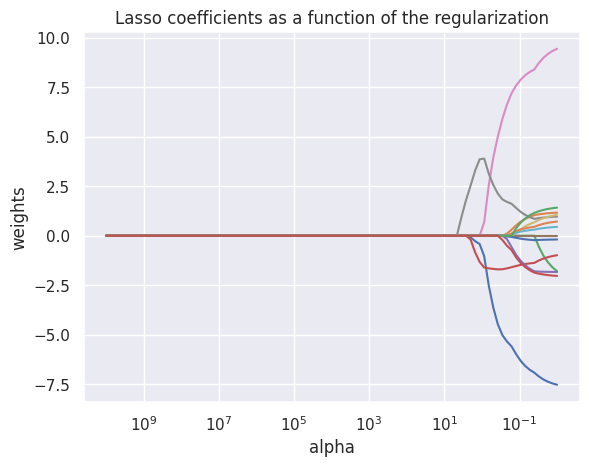

In [76]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [77]:
lassocv = LassoCV(alphas=None, cv=kf, max_iter=10000)
lassocv.fit(x_train_scaled, y_train.values.ravel())

LassoCV(cv=KFold(n_splits=5, random_state=2, shuffle=True), max_iter=10000)

In [78]:
lassocv.alpha_

0.0360710795426048

In [79]:
X_scale_t = scaler.transform(X_test)

In [80]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(x_train_scaled, y_train)
mean_squared_error(y_test, lasso.predict(X_scale_t))

19.05168695454772

In [81]:
# fit the full model
lasso.fit(scale(X), y)

Lasso(alpha=0.0360710795426048, max_iter=10000)

In [82]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

Sex       -7.523974
Age        1.272063
Weight    -1.775365
Height    -0.764233
Neck      -1.537046
Chest     -0.024020
Abdomen    9.756307
Hip        0.801442
Thigh      0.600530
Knee       0.690366
Ankle     -0.000000
Biceps     0.635694
Forearm    0.958525
Wrist     -1.880273
dtype: float64

### DecisionTreeRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# hyperparameter（'n_estimators', 'max_depth', 'max_samples'）
rf_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],  # 決策樹的數量
    'max_depth': [3, 4, 5],  # 決策樹的最大深度
    'max_samples': [0.7, 0.8, 0.9]  # 每棵樹的樣本比例
}

grid_search = GridSearchCV(rf_model, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(x_train_scaled, y_train)

# 獲取最佳超參數
best_params = grid_search.best_params_

# 列印最佳超參數
print("best_parameters：", best_params)

best_parameters： {'max_depth': 5, 'max_samples': 0.9, 'n_estimators': 200}


In [ ]:
# model
model = RandomForestRegressor(**best_params)

# train
model.fit(x_train_scaled, y_train)

RandomForestRegressor(max_depth=5, max_samples=0.9, n_estimators=200)

In [ ]:
n = len(y)
k = X.shape[1]

# eval on train data
y_train_pred = model.predict(x_train_scaled)

mse_train = mean_squared_error(y_train, y_train_pred).round(3)
mae_train = mean_absolute_error(y_train, y_train_pred).round(3)
r2_train = r2_score(y_train, y_train_pred).round(3)
adj_r2_train = 1 - ((1 - r2_train) * (n - 1) / (n - k - 1))

# eval on test data
y_test_pred = model.predict(x_test_scaled)

mse_test = mean_squared_error(y_test, y_test_pred).round(3)
mae_test = mean_absolute_error(y_test, y_test_pred).round(3)
r2_test = r2_score(y_test, y_test_pred).round(3)
adj_r2_test = 1 - ((1 - r2_test) * (n - 1) / (n - k - 1))

print(f"Train | Mean Squared Error: {mse_train} | Mean Absolute Error: {mae_train} | R-squared: {r2_train}| adj-R2: {adj_r2_train}")
print(f"Test | Mean Squared Error: {mse_test} | Mean Absolute Error: {mae_test} | R-squared: {r2_test}| adj-R2: {adj_r2_test}")

Train | Mean Squared Error: 9.953 | Mean Absolute Error: 2.602 | R-squared: 0.826| adj-R2: 0.8202137767220903
Test | Mean Squared Error: 24.746 | Mean Absolute Error: 3.811 | R-squared: 0.524| adj-R2: 0.5081710213776722


In [ ]:
results = cross_validate(model, X, y, cv=kf, scoring=scoring)

average_mse = -results['test_MSE'].mean().round(3)
average_r2 = results['test_R-squared'].mean().round(3)
average_mae = -results['test_MAE'].mean().round(3)
average_adj_r2 = results['test_adj-R2'].mean()

print(f"KFold | Mean Squared Error: {average_mse} | Mean Absolute Error: {average_mae} | R-squared: {average_r2}| adj-R2: {average_adj_r2}")

KFold | Mean Squared Error: 20.156 | Mean Absolute Error: 3.598 | R-squared: 0.641| adj-R2: 0.5713418178821088


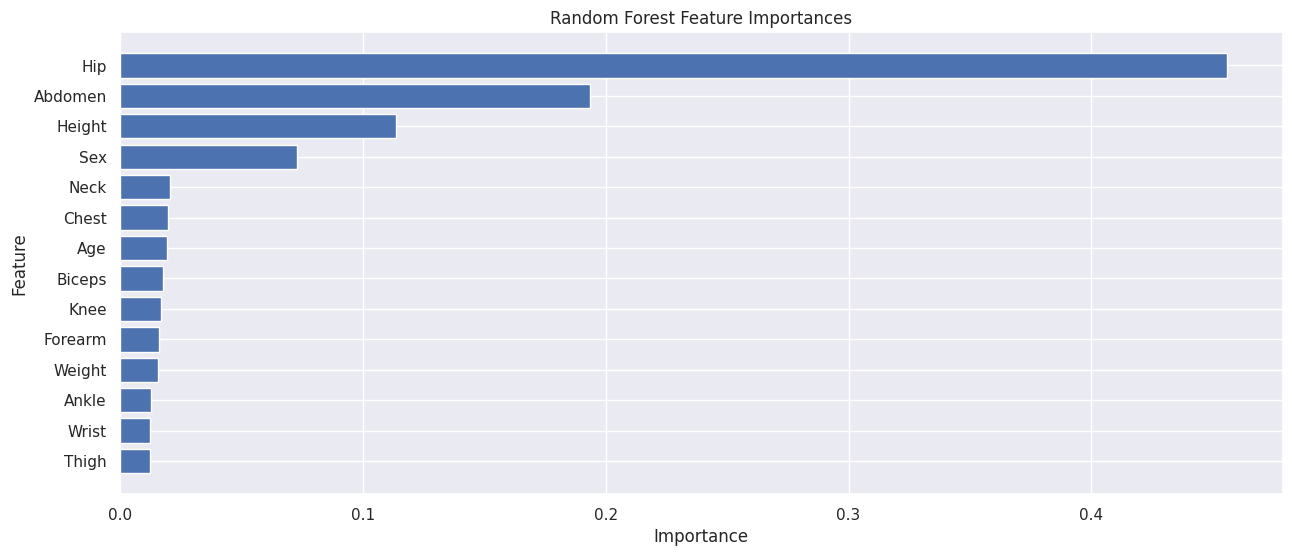

In [ ]:
# Get feature importances for all trees in the random forest
feature_importances = model.feature_importances_



# Create indices sorted in ascending order of feature importance
feature_names = X_train.columns
sorted_indices = np.argsort(feature_importances)

# Reorder feature names and feature importances based on the sorted indices
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

# Plot feature importances in ascending order
plt.figure(figsize=(15, 6))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()

tree 180 in forest:


[Text(0.625, 0.9166666666666666, 'Hip <= 0.644\nsquared_error = 58.921\nsamples = 100.0%\nvalue = 19.731'),
 Text(0.35555555555555557, 0.75, 'Sex <= -0.171\nsquared_error = 45.096\nsamples = 79.1%\nvalue = 17.881'),
 Text(0.17777777777777778, 0.5833333333333334, 'Abdomen <= -1.05\nsquared_error = 29.444\nsamples = 34.5%\nvalue = 20.852'),
 Text(0.08888888888888889, 0.4166666666666667, 'Hip <= -1.31\nsquared_error = 20.789\nsamples = 18.0%\nvalue = 17.375'),
 Text(0.044444444444444446, 0.25, 'Thigh <= -1.679\nsquared_error = 8.962\nsamples = 4.9%\nvalue = 13.184'),
 Text(0.022222222222222223, 0.08333333333333333, 'squared_error = 2.719\nsamples = 1.9%\nvalue = 10.314'),
 Text(0.06666666666666667, 0.08333333333333333, 'squared_error = 4.499\nsamples = 2.9%\nvalue = 14.978'),
 Text(0.13333333333333333, 0.25, 'Ankle <= -0.609\nsquared_error = 16.926\nsamples = 13.1%\nvalue = 18.772'),
 Text(0.1111111111111111, 0.08333333333333333, 'squared_error = 14.635\nsamples = 9.2%\nvalue = 20.408'),


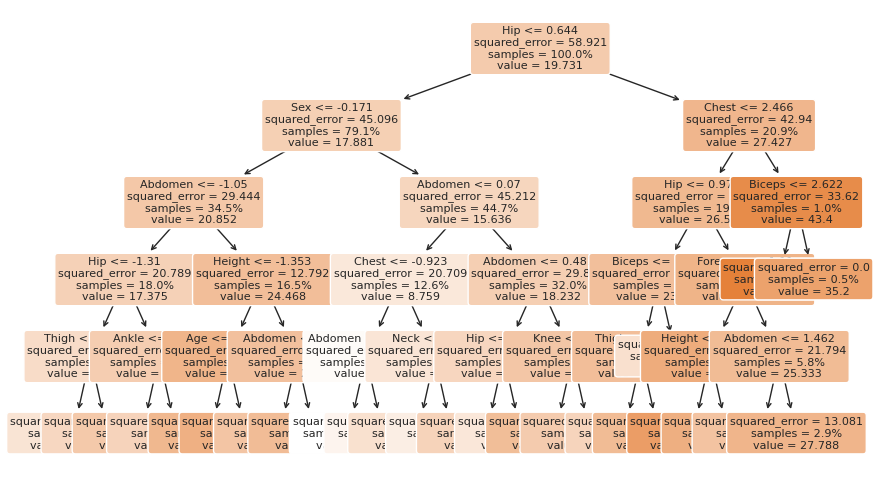

In [ ]:
# 隨機畫出一棵樹
import random
from sklearn.tree import plot_tree

n_estimators = best_params['n_estimators']
random_index = random.randint(0, n_estimators-1)
random_tree = model.estimators_[random_index]
print(f"tree {random_index} in forest:")
plt.figure(figsize=(10, 6))
plot_tree(random_tree, max_depth=5, feature_names=X_train.columns, fontsize=8, filled=True, proportion=True, rounded=True)

###GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# hyperparameter（'n_estimators', 'max_depth', 'learning_rate'）
gb_model = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],  # 決策樹的數量
    'max_depth': [3, 4, 5],  # 決策樹的最大深度
    'learning_rate': [0.01, 0.1, 0.2]  # 學習速率
}

grid_search = GridSearchCV(gb_model, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(x_train_scaled, y_train)

best_params = grid_search.best_params_

print("best parameters：", best_params)

best parameters： {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [ ]:
# model
model = GradientBoostingRegressor(**best_params)

# train
model.fit(x_train_scaled, y_train)

GradientBoostingRegressor(n_estimators=50)

In [ ]:
n = len(y)
k = X.shape[1]

# eval on train data
y_train_pred = model.predict(x_train_scaled)

mse_train = mean_squared_error(y_train, y_train_pred).round(3)
mae_train = mean_absolute_error(y_train, y_train_pred).round(3)
r2_train = r2_score(y_train, y_train_pred).round(3)
adj_r2_train = 1 - ((1 - r2_train) * (n - 1) / (n - k - 1))

# eval on test data
y_test_pred = model.predict(x_test_scaled)

mse_test = mean_squared_error(y_test, y_test_pred).round(3)
mae_test = mean_absolute_error(y_test, y_test_pred).round(3)
r2_test = r2_score(y_test, y_test_pred).round(3)
adj_r2_test = 1 - ((1 - r2_test) * (n - 1) / (n - k - 1))

print(f"Train | Mean Squared Error: {mse_train} | Mean Absolute Error: {mae_train} | R-squared: {r2_train}| adj-R2: {adj_r2_train}")
print(f"Test | Mean Squared Error: {mse_test} | Mean Absolute Error: {mae_test} | R-squared: {r2_test}| adj-R2: {adj_r2_test}")

Train | Mean Squared Error: 7.852 | Mean Absolute Error: 2.252 | R-squared: 0.863| adj-R2: 0.8584441805225653
Test | Mean Squared Error: 23.143 | Mean Absolute Error: 3.714 | R-squared: 0.555| adj-R2: 0.5402019002375298


In [ ]:
scoring = {'MSE': 'neg_mean_squared_error',
           'MAE': 'neg_mean_absolute_error',
           'R-squared': 'r2',
           'adj-R2': make_scorer(adjusted_r2, num_features=X.shape[1])}

results = cross_validate(model, X, y, cv=kf, scoring=scoring)

average_mse = -results['test_MSE'].mean().round(3)
average_r2 = results['test_R-squared'].mean().round(3)
average_mae = -results['test_MAE'].mean().round(3)
average_adj_r2 = results['test_adj-R2'].mean()

print(f"KFold | Mean Squared Error: {average_mse} | Mean Absolute Error: {average_mae} | R-squared: {average_r2}| adj-R2: {average_adj_r2}")

KFold | Mean Squared Error: 19.725 | Mean Absolute Error: 3.529 | R-squared: 0.649| adj-R2: 0.5803328714331111
